<a href="https://colab.research.google.com/github/abhigyanpal1/aave-credit-scorer/blob/main/credit_score_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pandas numpy scikit-learn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 129.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 126.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: matplotlib
    Found ex

In [4]:
import json
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

# Path to your uploaded JSON
json_path = '/user-wallet-transactions.json'


In [5]:
!pip install ijson


In [6]:
# Map token symbols to their on‑chain decimals
DECIMALS = {'USDC':6, 'USDT':6, 'DAI':18, 'WMATIC':18}

def load_raw_json(path: str) -> pd.DataFrame:
    with open(path, 'r') as f:
        data = json.load(f)
    rows = []
    for e in data:
        amt_raw = int(e['actionData']['amount'])
        dec    = DECIMALS.get(e['actionData']['assetSymbol'], 18)
        amt    = amt_raw / (10 ** dec)
        rows.append({
            'userWallet':    e['userWallet'],
            'action':        e['action'],
            'timestamp':     datetime.fromtimestamp(e['timestamp']),
            'assetSymbol':   e['actionData']['assetSymbol'],
            'amount':        amt,
            'assetPriceUSD': float(e['actionData']['assetPriceUSD']),
        })
    return pd.DataFrame(rows)

# Load into DataFrame
df = load_raw_json(json_path)
print("Loaded", len(df), "transactions for", df['userWallet'].nunique(), "wallets.")
df.head()


Loaded 100000 transactions for 3497 wallets.


,userWallet,action,timestamp,assetSymbol,amount,assetPriceUSD
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,deposit,2021-08-17 05:29:26,USDC,2000.000000,0.993832
1,0x000000000051d07a4fb3bd10121a343d85818da6,deposit,2021-05-20 15:36:53,WMATIC,145.000000,1.970307
2,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,2021-07-24 09:28:33,WMATIC,0.001000,0.922377
3,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,2021-07-31 23:15:18,WMATIC,0.004000,1.057483
4,0x0000000000e189dd664b9ab08a33c4839953852c,redeemunderlying,2021-04-19 15:25:07,USDC,0.501548,1.002130


In [7]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    now = df['timestamp'].max()
    feats = []
    for wallet, sub in df.groupby('userWallet'):
        counts = sub['action'].value_counts().to_dict()
        sums   = sub.groupby('action')['amount'].sum().to_dict()
        borrow = counts.get('borrow', 0)
        repay  = counts.get('repay', 0)
        feats.append({
            'userWallet':      wallet,
            'n_deposits':      counts.get('deposit', 0),
            'total_deposit':   sums.get('deposit', 0.0),
            'n_borrows':       borrow,
            'total_borrow':    sums.get('borrow', 0.0),
            'repay_ratio':     repay/borrow if borrow>0 else 0.0,
            'n_liquidations':  counts.get('liquidationcall', 0),
            'distinct_assets': sub['assetSymbol'].nunique(),
            'days_since_last': (now - sub['timestamp'].max()).days,
        })
    return pd.DataFrame(feats).fillna(0)

# Build feature DataFrame
feats = engineer_features(df)
print("Engineered", feats.shape[1]-1, "features for", len(feats), "wallets.")
feats.head()


Engineered 8 features for 3497 wallets.


,userWallet,n_deposits,total_deposit,n_borrows,total_borrow,repay_ratio,n_liquidations,distinct_assets,days_since_last
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,2000.000000,0,0.0,0.000000,0,1,16
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,145.000000,0,0.0,0.000000,0,1,105
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,0.005000,0,0.0,0.000000,0,1,32
3,0x0000000000e189dd664b9ab08a33c4839953852c,0,0.000000,0,0.0,0.000000,0,4,6
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,250,814108.403292,15,109460.0,0.266667,0,6,0


In [8]:
def train_model(feat_df):
    X = feat_df.drop('userWallet', axis=1).values
    scaler = MinMaxScaler().fit(X)
    iso    = IsolationForest(contamination=0.05, random_state=42).fit(scaler.transform(X))
    return scaler, iso

def score_wallets(feat_df, scaler, model):
    X = feat_df.drop('userWallet', axis=1).values
    Xs = scaler.transform(X)
    raw = model.decision_function(Xs)               # higher = more “normal”
    mn, mx = raw.min(), raw.max()
    norm   = (raw - mn) / (mx - mn + 1e-9)
    scores = (norm * 1000).astype(int)
    out    = feat_df[['userWallet']].copy()
    out['score'] = scores
    return out

# Train & score
scaler, iso     = train_model(feats)
scored_df       = score_wallets(feats, scaler, iso)
scored_df.to_csv('scores.csv', index=False)
print("Scored", len(scored_df), "wallets. First few rows:")
scored_df.head()


Scored 3497 wallets. First few rows:


,userWallet,score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,948
1,0x000000000051d07a4fb3bd10121a343d85818da6,948
2,0x000000000096026fb41fc39f9875d164bd82e2dc,981
3,0x0000000000e189dd664b9ab08a33c4839953852c,899
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,349


In [9]:
# Quick peek:
!head -n 10 scores.csv

# Or to download locally:
from google.colab import files
files.download('scores.csv')


userWallet,score
0x00000000001accfa9cef68cf5371a23025b6d4b6,948
0x000000000051d07a4fb3bd10121a343d85818da6,948
0x000000000096026fb41fc39f9875d164bd82e2dc,981
0x0000000000e189dd664b9ab08a33c4839953852c,899
0x0000000002032370b971dabd36d72f3e5a7bf1ee,349
0x000000000a38444e0a6e37d3b630d7e855a7cb13,836
0x000000003853fcedcd0355fec98ca3192833f00b,798
0x000000003ce0cf2c037493b1dc087204bd7f713e,342
0x000000007858e6f2668e1e06111cfa24403a5466,960


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

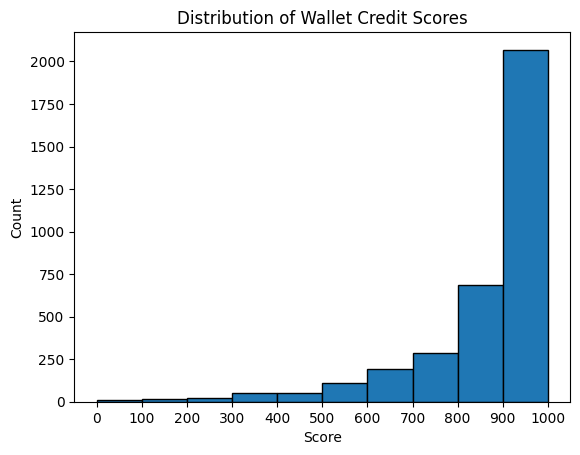

In [10]:
plt.hist(scored_df['score'], bins=range(0,1001,100), edgecolor='k')
plt.title('Distribution of Wallet Credit Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(range(0,1001,100))
plt.show()
